# 第8章

## 挿入用のコード

In [1]:
#---- ch08/import
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing()

In [2]:
#---- ch08/define-symbols
k1, k0, c1, c0, g, n = sp.symbols("k1 k0 c1 c0 g n")
alpha, beta, delta, theta = sp.symbols("alpha beta delta theta")

In [3]:
#---- ch08/production
f = sp.Lambda(k0, k0**alpha)
f(k0)

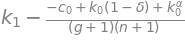

In [4]:
#---- ch08/dynamics-k
EK = k1 - (f(k0) - c0 + (1 - delta) * k0) / (1 + g) / (1 + n) 
EK

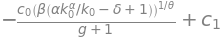

In [5]:
#---- ch08/dynamics-c
EC = c1 - c0 * (beta * (f(k0).diff(k0) + 1 - delta)) ** (1 / theta) / (1 + g)
EC

In [6]:
#---- ch08/steady-state
E = sp.Matrix([EK, EC]).subs({k1: k0, c1: c0})
E

⎡                               α     ⎤
⎢          -c₀ + k₀⋅(1 - δ) + k₀      ⎥
⎢     k₀ - ──────────────────────     ⎥
⎢             (g + 1)⋅(n + 1)         ⎥
⎢                                     ⎥
⎢             ___________________     ⎥
⎢            ╱   ⎛    α        ⎞      ⎥
⎢           ╱    ⎜α⋅k₀         ⎟      ⎥
⎢  c₀⋅theta╱   β⋅⎜───── - δ + 1⎟      ⎥
⎢        ╲╱      ⎝  k₀         ⎠      ⎥
⎢- ────────────────────────────── + c₀⎥
⎣              g + 1                  ⎦

In [7]:
#---- ch08/parameters
params = {
    alpha: 0.33,
    delta: 0.03,
    g: 0.02,
    n: 0.01,
    theta: 0.8,
    beta: 0.98
}

In [8]:
#---- ch08/lambdify
E_lam = sp.lambdify([[k0, c0]], np.squeeze(E.subs(params)))
J_lam = sp.lambdify([[k0, c0]], E.jacobian([k0, c0]).subs(params))

In [9]:
#---- ch08/solve-for-ss
ss = fsolve(func=E_lam, x0=[4, 4], fprime=J_lam)
ss

array([10.87371171,  1.54328611])

In [10]:
#---- ch08/many-symbols
T = 80
c = sp.symbols(f"c[:{T+2}]")
k = sp.symbols(f"k[:{T+1}]")

c[:3], c[-3:]

In [11]:
#---- ch08/equilibrium-equation
eqm = sp.Matrix([[EK.subs({k0: k[i], k1: k[i+1], c0: c[i+1], c1: c[i+2]}),
                  EC.subs({k0: k[i], k1: k[i+1], c0: c[i+1], c1: c[i+2]})] 
                  for i in range(T)])
eqm[:3, :]

⎡                                                    _____________________    
⎢                                                   ╱   ⎛      α        ⎞     
⎢                                                  ╱    ⎜α⋅k[0]         ⎟     
⎢                                  α    c[1]⋅theta╱   β⋅⎜─────── - δ + 1⎟     
⎢       -c[1] + k[0]⋅(1 - δ) + k[0]             ╲╱      ⎝  k[0]         ⎠     
⎢k[1] - ────────────────────────────  - ────────────────────────────────── + c
⎢             (g + 1)⋅(n + 1)                         g + 1                   
⎢                                                                             
⎢                                                    _____________________    
⎢                                                   ╱   ⎛      α        ⎞     
⎢                                                  ╱    ⎜α⋅k[1]         ⎟     
⎢                                  α    c[2]⋅theta╱   β⋅⎜─────── - δ + 1⎟     
⎢       -c[2] + k[1]⋅(1 - δ) + k[1]             ╲╱  

In [12]:
#---- ch08/make-column
eqm_col = eqm.T.reshape(2*T, 1)
eqm_col[:3, :], eqm_col[T:T+3, :]

⎛                                       ⎡               _____________________ 
⎜                                       ⎢              ╱   ⎛      α        ⎞  
⎜                                       ⎢             ╱    ⎜α⋅k[0]         ⎟  
⎜                                       ⎢  c[1]⋅theta╱   β⋅⎜─────── - δ + 1⎟  
⎜⎡                                  α⎤  ⎢          ╲╱      ⎝  k[0]         ⎠  
⎜⎢       -c[1] + k[0]⋅(1 - δ) + k[0] ⎥  ⎢- ────────────────────────────────── 
⎜⎢k[1] - ────────────────────────────⎥  ⎢                g + 1                
⎜⎢             (g + 1)⋅(n + 1)       ⎥  ⎢                                     
⎜⎢                                   ⎥  ⎢               _____________________ 
⎜⎢                                  α⎥  ⎢              ╱   ⎛      α        ⎞  
⎜⎢       -c[2] + k[1]⋅(1 - δ) + k[1] ⎥  ⎢             ╱    ⎜α⋅k[1]         ⎟  
⎜⎢k[2] - ────────────────────────────⎥, ⎢  c[2]⋅theta╱   β⋅⎜─────── - δ + 1⎟  
⎜⎢             (g + 1)⋅(n + 1)       ⎥  ⎢          ╲

In [13]:
#---- ch08/solve
k_init = 1.0

eqm_param = eqm_col.subs(params).subs({k[0]: k_init, c[-1]: ss[1]})
eqm_param = np.squeeze(eqm_param)
eqm_num = sp.lambdify([[*k[1:], *c[1:-1]]], eqm_param)
solution = fsolve(eqm_num, x0=np.ones(2*T))

In [14]:
#---- ch08/k-and-c
k_sol = np.r_[k_init, solution[:T]]
c_sol = np.r_[solution[T:], ss[1]]

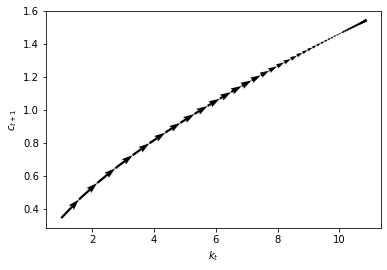

In [15]:
#---- ch08/show/plot
plt.quiver(k_sol[:-1], c_sol[:-1], 
           k_sol[1:] - k_sol[:-1], 
           c_sol[1:] - c_sol[:-1],
           scale_units='xy', angles='xy', scale=1)

plt.xlabel(r"$k_{t}$")
plt.ylabel(r"$c_{t+1}$")
plt.show()

In [16]:
#---- ch08/solve_ss
def solve_ss(eqm_k, eqm_c, param, x0):
    c, k = sp.symbols("c, k")
    eqm = sp.Matrix([eqm_k.subs({k0: k, k1: k, c0: c, c1: c}),
                     eqm_c.subs({k0: k, k1: k, c0: c, c1: c})])
    
    eqm_lam = sp.lambdify([[k, c]], np.squeeze(eqm.subs(param)))
    J_lam = sp.lambdify([[k, c]], eqm.jacobian([k, c]).subs(param))
    
    ss = fsolve(func=eqm_lam, x0=x0, fprime=J_lam)
    return ss

In [17]:
#---- ch08/solve_optimal_growth
def solve_optimal_growth(eqm_k, eqm_c, k_init, c_final, param, T):
    
    c = sp.symbols(f"c[:{T+2}]")
    k = sp.symbols(f"k[:{T+1}]")
    eqm = sp.Matrix([[eqm_k.subs({k0: k[i], k1: k[i+1], c0: c[i+1], c1: c[i+2]}),
                      eqm_c.subs({k0: k[i], k1: k[i+1], c0: c[i+1], c1: c[i+2]})] 
                      for i in range(T)])
    eqm_col = eqm.T.reshape(2*T, 1)
    
    eqm_param = eqm_col.subs(param).subs({k[0]: k_init, c[-1]: c_final})
    eqm_param = np.squeeze(eqm_param)
    
    eqm_num = sp.lambdify([[*k[1:], *c[1:-1]]], eqm_param)
    solution = fsolve(eqm_num, x0=np.ones(2*T))
    
    k_sol = np.r_[k_init, solution[:T]]
    c_sol = np.r_[solution[T:], c_final]
    
    return (k_sol, c_sol)

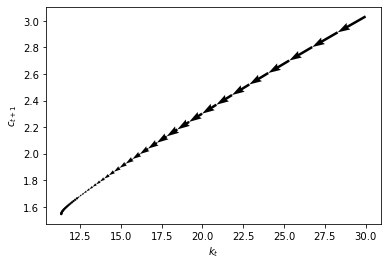

In [18]:
#---- ch08/example/plot
ss1 = solve_ss(EK, EC, params, x0=[4, 4])
k_sol, c_sol = solve_optimal_growth(EK, EC, 30.0, ss1[1], params, 50)

plt.quiver(k_sol[:-1], c_sol[:-1], 
           k_sol[1:] - k_sol[:-1], 
           c_sol[1:] - c_sol[:-1],
           scale_units='xy', angles='xy', scale=1)

plt.xlabel(r"$k_{t}$")
plt.ylabel(r"$c_{t+1}$")
plt.show()

In [19]:
#---- ch08/new-ss
params.update({g: 0.03})
ss2 = solve_ss(EK, EC, params, x0=[4, 4])

In [20]:
#---- ch08/transition
sol2 = solve_optimal_growth(EK, EC, ss1[0], ss2[1], params, 80)
k_sol2 = np.r_[ss1[0], sol2[0]] 
c_sol2 = np.r_[ss1[1], sol2[1]]

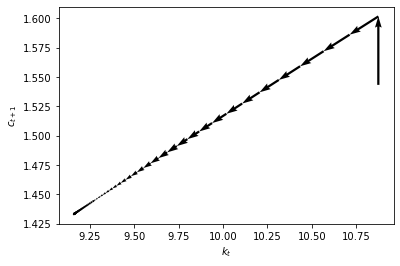

In [21]:
#---- ch08/transition-plot/plot
plt.quiver(k_sol2[:-1], c_sol2[:-1], 
           k_sol2[1:] - k_sol2[:-1], 
           c_sol2[1:] - c_sol2[:-1],
           scale_units='xy', angles='xy', scale=1)

plt.xlabel(r"$k_{t}$")
plt.ylabel(r"$c_{t+1}$")
plt.show()

## 編集用コード

In [22]:
#---- ch08/for-pdf-only/noinc
# PDF出力用のコード
sp.init_printing(pretty_printer=sp.printing.latex)